In [1]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.svm import SVR
from sklearn import linear_model
import pickle
import numpy as np
import pandas as pd
import xgboost as xg
import lightgbm as lgb

In [2]:
df = pd.read_csv('train_data.csv', index_col=0)
weight = []

FileNotFoundError: ignored

In [ ]:
df=df[df["Weight"]!='Not Available']

In [ ]:
for index,row in df.iterrows():
    weight.append(row["Weight"].split()[0])

In [ ]:
df["weight"]=weight

In [ ]:
df = df.astype({"weight": int})

In [ ]:
X = df.drop(["Weight","weight","ID"],axis=1).to_numpy()

In [ ]:
y = df["weight"].to_numpy()

In [ ]:
kf = KFold(n_splits=5)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
param_grid_lgb = {
"n_estimators": 1540,
"learning_rate": 0.12451150300990464,
"num_leaves": 2180,
"max_depth": 4,
"min_data_in_leaf": 400,
"max_bin": 233,
"lambda_l1": 15,
"lambda_l2": 0,
"min_gain_to_split": 10.488481350873686,
"bagging_fraction": 0.8,
"bagging_freq": 1,
"feature_fraction": 0.9,
}

param_grid_xg = {
"lr": 0.011334813373338989,
"n_estimators": 2333,
"max_depth": 5,
"subsample": 0.8486443999034436,
"colsample_bytree": 0.767195468916397,
"gamma": 2,
"early_stopping_rounds": 55
}

param_grid_nn = {
    "layers" : [64,117,97],
    "lr" : 0.004658308827365093
}


In [ ]:
def eval_metric(y_true,y_pred):
    return "mae",mean_absolute_error(y_true, y_pred),False

In [ ]:
score = -999999999999999
for train_index, test_index in kf.split(X_train):
    
    X_train_k_fold, X_test_k_fold, y_train_k_fold, y_test_k_fold = X_train[train_index],X_train[test_index],y_train[train_index],y_train[test_index]
    
    model1 = lgb.LGBMRegressor(objective="regression", **param_grid_lgb)
    model2 = xg.XGBRegressor(objective ='reg:squarederror',
                  n_estimators = param_grid_xg["n_estimators"],learning_rate = param_grid_xg["lr"],max_depth = param_grid_xg["max_depth"],subsample = param_grid_xg["subsample"],colsample_bytree = param_grid_xg["colsample_bytree"],gamma = param_grid_xg["gamma"], seed = 0)

    model3 = MLPRegressor(hidden_layer_sizes=param_grid_nn["layers"] , learning_rate_init=param_grid_nn["lr"],random_state=0, max_iter=1500)
    
    model1.fit(
    X_train_k_fold,
    y_train_k_fold,
    eval_set=[(X_test_k_fold, y_test_k_fold)],
    eval_metric=eval_metric,
    early_stopping_rounds=100,
    verbose = False,
    )
    
    model2.fit(X_train_k_fold,y_train_k_fold,early_stopping_rounds = param_grid_xg["early_stopping_rounds"],eval_set = [(X_test_k_fold, y_test_k_fold)],verbose = False,eval_metric = "mae")
    
    model3.fit(X_train_k_fold,y_train_k_fold)
    
    y_pred_model1 = model1.predict(X_test_k_fold)
    y_pred_model2 = model2.predict(X_test_k_fold)
    y_pred_model3 = model3.predict(X_test_k_fold)
        
    features = np.vstack((y_pred_model1,y_pred_model2,y_pred_model3))
    features = features.transpose()
    
    regr = MLPRegressor(random_state=1, max_iter=500).fit(features, y_test_k_fold)

    # regr = make_pipeline(StandardScaler(), linear_model.LassoLars(alpha=.1, normalize=False))
    # regr.fit(features,y_test_k_fold)
    # reg = LinearRegression().fit(features,y_test_k_fold)
    curr_score = reg.score(features,y_test_k_fold)

    if curr_score > score:
      score = curr_score
      filename = 'best_model_MLP.sav'
      pickle.dump(reg, open(filename, 'wb'))
      pickle.dump(model3, open("best_nn.sav", 'wb'))
      # model2.save_model("best_xgboost.json")
      model2.save_model("best_xgboost.txt")
      model1.booster_.save_model('best_lgbm.txt')


#     y_pred_model1_list.append(y_pred_model1)
#     y_pred_model2_list.append(y_pred_model2)
#     y_pred_model3_list.append(y_pred_model3)
    

In [ ]:
model1 = lgb.Booster(model_file='best_lgbm.txt')
model2 = xg.XGBRegressor()
model2.load_model("best_xgboost.txt")
model3 = pickle.load(open("best_nn.sav", 'rb'))

meta_model = pickle.load(open("best_model_SVM.sav", 'rb'))

In [ ]:
y_pred_model1 = model1.predict(X_test)
y_pred_model2 = model2.predict(X_test)
y_pred_model3 = model3.predict(X_test)

model1_stat = [0] * 12
model2_stat = [0] * 12
model3_stat = [0] * 12

meta_model_stat = [0] * 12

for x, (i, j) in enumerate(zip(y_pred_model1, y_test)):
    
    if round(abs(i-j),0)<=5 and round(abs(i-j),0)>=0:
          model1_stat[0]=model1_stat[0]+1
       
    if round(abs(i-j),0)<=10 and round(abs(i-j),0)>=6:
          model1_stat[1]=model1_stat[1]+1
          
    if round(abs(i-j),0)<=20 and round(abs(i-j),0)>=11:
          model1_stat[2]=model1_stat[2]+1
       
    if round(abs(i-j),0)<=30 and round(abs(i-j),0)>=21:
          model1_stat[3]=model1_stat[3]+1
         
    if round(abs(i-j),0)<=40 and round(abs(i-j),0)>=31:
          model1_stat[4]=model1_stat[4]+1
          
    if round(abs(i-j),0)<=50 and round(abs(i-j),0)>=41:
          model1_stat[5]=model1_stat[5]+1
        
    if round(abs(i-j),0)<=60 and round(abs(i-j),0)>=51:
          model1_stat[6]=model1_stat[6]+1
      
    if round(abs(i-j),0)<=70 and round(abs(i-j),0)>=61:
          model1_stat[7]=model1_stat[7]+1
        
    if round(abs(i-j),0)<=80 and round(abs(i-j),0)>=71:
          model1_stat[8]=model1_stat[8]+1
          
    if round(abs(i-j),0)<=90 and round(abs(i-j),0)>=81:
          model1_stat[9]=model1_stat[9]+1
         
    if round(abs(i-j),0)<=100 and round(abs(i-j),0)>=91:
          model1_stat[10]=model1_stat[10]+1
         

    if round(abs(i-j),0)>100:
          model1_stat[11]=model1_stat[11]+1
          
 


for x, (i, j) in enumerate(zip(y_pred_model2, y_test)):
    if round(abs(i-j),0)<=5 and round(abs(i-j),0)>=0:
          model2_stat[0]=model2_stat[0]+1
    if round(abs(i-j),0)<=10 and round(abs(i-j),0)>=6:
          model2_stat[1]=model2_stat[1]+1
    if round(abs(i-j),0)<=20 and round(abs(i-j),0)>=11:
          model2_stat[2]=model2_stat[2]+1
    if round(abs(i-j),0)<=30 and round(abs(i-j),0)>=21:
          model2_stat[3]=model2_stat[3]+1
    if round(abs(i-j),0)<=40 and round(abs(i-j),0)>=31:
          model2_stat[4]=model2_stat[4]+1
    if round(abs(i-j),0)<=50 and round(abs(i-j),0)>=41:
          model2_stat[5]=model2_stat[5]+1
    if round(abs(i-j),0)<=60 and round(abs(i-j),0)>=51:
          model2_stat[6]=model2_stat[6]+1
    if round(abs(i-j),0)<=70 and round(abs(i-j),0)>=61:
          model2_stat[7]=model2_stat[7]+1
    if round(abs(i-j),0)<=80 and round(abs(i-j),0)>=71:
          model2_stat[8]=model2_stat[8]+1
    if round(abs(i-j),0)<=90 and round(abs(i-j),0)>=81:
          model2_stat[9]=model2_stat[9]+1
    if round(abs(i-j),0)<=100 and round(abs(i-j),0)>=91:
          model2_stat[10]=model2_stat[10]+1
    if round(abs(i-j),0)>100:
          model2_stat[11]=model2_stat[11]+1

for x, (i, j) in enumerate(zip(y_pred_model3, y_test)):
    if round(abs(i-j),0)<=5 and round(abs(i-j),0)>=0:
          model3_stat[0]=model3_stat[0]+1
    if round(abs(i-j),0)<=10 and round(abs(i-j),0)>=6:
          model3_stat[1]=model3_stat[1]+1
    if round(abs(i-j),0)<=20 and round(abs(i-j),0)>=11:
          model3_stat[2]=model3_stat[2]+1
    if round(abs(i-j),0)<=30 and round(abs(i-j),0)>=21:
          model3_stat[3]=model3_stat[3]+1
    if round(abs(i-j),0)<=40 and round(abs(i-j),0)>=31:
          model3_stat[4]=model3_stat[4]+1
    if round(abs(i-j),0)<=50 and round(abs(i-j),0)>=41:
          model3_stat[5]=model3_stat[5]+1
    if round(abs(i-j),0)<=60 and round(abs(i-j),0)>=51:
          model3_stat[6]=model3_stat[6]+1
    if round(abs(i-j),0)<=70 and round(abs(i-j),0)>=61:
          model3_stat[7]=model3_stat[7]+1
    if round(abs(i-j),0)<=80 and round(abs(i-j),0)>=71:
          model3_stat[8]=model3_stat[8]+1
    if round(abs(i-j),0)<=90 and round(abs(i-j),0)>=81:
          model3_stat[9]=model3_stat[9]+1
    if round(abs(i-j),0)<=100 and round(abs(i-j),0)>=91:
          model3_stat[10]=model3_stat[10]+1
    if round(abs(i-j),0)>100:
          model3_stat[11]=model3_stat[11]+1

features = np.vstack((y_pred_model1,y_pred_model2,y_pred_model3))
features = features.transpose()
y_pred = meta_model.predict(features)


for x, (i, j) in enumerate(zip(y_pred, y_test)):
    if round(abs(i-j),0)<=5 and round(abs(i-j),0)>=0:
          meta_model_stat[0]=meta_model_stat[0]+1
    if round(abs(i-j),0)<=10 and round(abs(i-j),0)>=6:
          meta_model_stat[1]=meta_model_stat[1]+1
    if round(abs(i-j),0)<=20 and round(abs(i-j),0)>=11:
          meta_model_stat[2]=meta_model_stat[2]+1
    if round(abs(i-j),0)<=30 and round(abs(i-j),0)>=21:
          meta_model_stat[3]=meta_model_stat[3]+1
    if round(abs(i-j),0)<=40 and round(abs(i-j),0)>=31:
          meta_model_stat[4]=meta_model_stat[4]+1
    if round(abs(i-j),0)<=50 and round(abs(i-j),0)>=41:
          meta_model_stat[5]=meta_model_stat[5]+1
    if round(abs(i-j),0)<=60 and round(abs(i-j),0)>=51:
          meta_model_stat[6]=meta_model_stat[6]+1
    if round(abs(i-j),0)<=70 and round(abs(i-j),0)>=61:
          meta_model_stat[7]=meta_model_stat[7]+1
    if round(abs(i-j),0)<=80 and round(abs(i-j),0)>=71:
          meta_model_stat[8]=meta_model_stat[8]+1
    if round(abs(i-j),0)<=90 and round(abs(i-j),0)>=81:
          meta_model_stat[9]=meta_model_stat[9]+1
    if round(abs(i-j),0)<=100 and round(abs(i-j),0)>=91:
          meta_model_stat[10]=meta_model_stat[10]+1
    if round(abs(i-j),0)>100:
          meta_model_stat[11]=meta_model_stat[11]+1
print("meta_model",mean_absolute_error(y_test, y_pred))
print("lightgbm:",mean_absolute_error(y_test, y_pred_model1))
print("xgboost:",mean_absolute_error(y_test, y_pred_model2))
print("NN:",mean_absolute_error(y_test, y_pred_model3))

meta_model 27.266674506500536
lightgbm: 27.560741982987636
xgboost: 27.306519930840913
NN: 27.52609709233549


In [ ]:
sum(model1_stat)

6930

In [ ]:
sum(model2_stat)

6930

In [ ]:
sum(model3_stat)

6930

In [ ]:
sum(meta_model_stat)

6930

In [ ]:
len(X_test)

6930

In [ ]:
for x,i in enumerate(model1_stat):
  model1_stat[x] = i * (100/6930)

In [ ]:
for x,i in enumerate(model2_stat):
  model2_stat[x] = i * (100/6930)

In [ ]:
for x,i in enumerate(model3_stat):
  model3_stat[x] = i * (100/6930)

In [ ]:
for x,i in enumerate(meta_model_stat):
  meta_model_stat[x] = i * (100/6930)

In [ ]:
len(model1_stat)

12

In [ ]:
import matplotlib.pyplot as plt

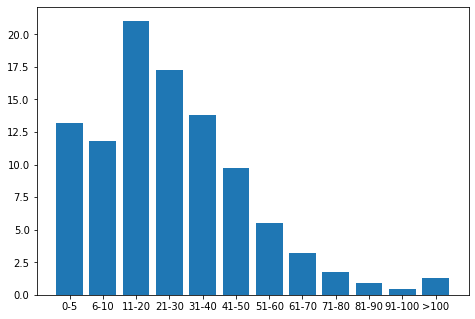

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
Range = ['0-5', '6-10', '11-20', '21-30', '31-40', '41-50' ,'51-60','61-70','71-80','81-90','91-100','>100']
ax.bar(Range,model1_stat)
plt.show()

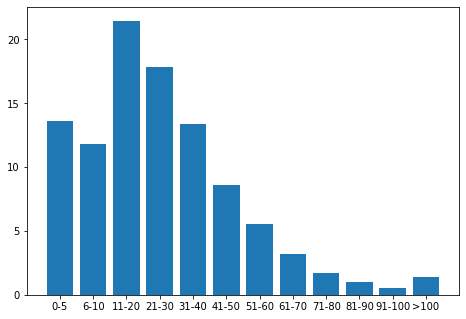

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
Range = ['0-5', '6-10', '11-20', '21-30', '31-40', '41-50' ,'51-60','61-70','71-80','81-90','91-100','>100']
ax.bar(Range,model2_stat)
plt.show()

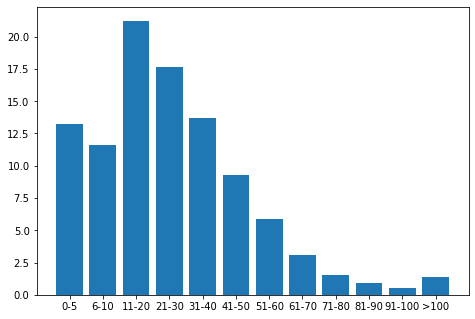

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
Range = ['0-5', '6-10', '11-20', '21-30', '31-40', '41-50' ,'51-60','61-70','71-80','81-90','91-100','>100']
ax.bar(Range,model3_stat)
plt.show()

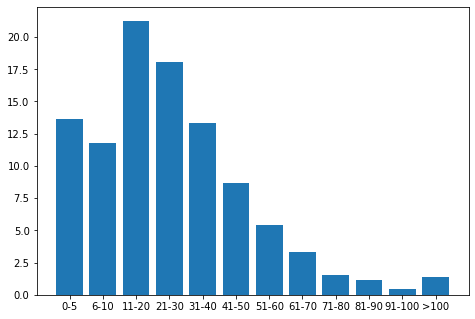

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
Range = ['0-5', '6-10', '11-20', '21-30', '31-40', '41-50' ,'51-60','61-70','71-80','81-90','91-100','>100']
ax.bar(Range,meta_model_stat)
plt.show()